# 1. Why am I getting this error:  Not enough samples to build a trace.  

I found that whether I use MCMC or variation bayes, sometimes Python stuck on the cell forever, so when I stop running the code by interrupting the kernel I get this message.

(This is a part from Mike's [overdose-model-intro](https://github.com/sempwn/overdose-model-intro/blob/master/model_introduction.ipynb) jupyter notebook. )
 
The problem occured when I was reproducing
 **Adapting the model to death data** chapter from his notebook.  
 Specifically, it works on this notebook (Questions.ipynb), but It does not work on my another notebook file which is  [reproducing the notebook from scratch](https://github.com/aiod01/Bayesian-evidence-synthesis-/blob/master/reproducing%20the%20repository%20from%20scratch.ipynb), where I was reproducing all Mike's work at his github repo.

Versions:  
pymc3:  3.7  
Python: 3.7.4


In [1]:
# installing packages

%pylab inline 
# magic fucntion in ipython. It loads major numerical and plotting libraries

import pandas as pd
import pymc3 as pm
# probabilistic programming language

# import class for constructing random walks
from pymc3.distributions.timeseries import GaussianRandomWalk
import theano.tensor as tt

#import some special methods
from scipy.special import logit,expit
import scipy.stats as stats

# set some plotting parameters to create ggplot-style plots
import seaborn as sns
import matplotlib as mpl
sns.set_context(context='talk',font_scale=1.5)
plt.style.use('ggplot')
mpl.rcParams['axes.labelsize'] = 24

#interactive plotting tools
from ipywidgets import interactive
matplotlib.rcParams['figure.figsize'] = [15,8]


Populating the interactive namespace from numpy and matplotlib


In [2]:
# version checks 
print(pm.__version__)
from platform import python_version
print(python_version())

3.7
3.7.4


I define two functions,   
one for creating the model, the other for generating trace, and ppc.

I changed some parts to adjust the changes of pymc3 updates from 3.0 to 3.7  

The model is as follow:  
N: population size
$$N \sim Normal(10000, 100)$$  


We assume the prevalence of overdoses can vary in time. We can assume that the prevalence of an overdose is only dependent on the overdoses in the previous month and there is a general increasing trend. The simplest way to incorporate this is to first define a random walk with drift, $w_t$. Each time-step can be normally distributed around the previous time-step with variance $\sigma_w^2$ and a drift $\mu_w$,

$$W_t \sim N(w_{t-1} + \mu_w,\sigma_w^2)$$

or alternatively,
$$W_t \sim W_{t-1} + N(\mu_w,\sigma_w^2)$$

The model below has a overdose rate p which is a inverse logit of w. 
We also used Poission approximation for Binomial(N,p).

In [3]:
# this is from Mike's notebook adjusting the difference between pymc3 3.0 and 3.7
def create_timeseries_death_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            mu_pd = 0.1, sigma_pd = 0.05,
                            overdoses = None,deaths = None):
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    mu_pd : float
        mean probability of death following an overdose
    sigma_pd : float
        sd probability of death following an overdose
    overdoses : numpy array
        overdose data
    deaths : numpy array
        death data
    
    Returns
    -------
    
    Pymc3 model
    
    """
    
    # instantiate model
    model = pm.Model()

    # create elements of the model
    with model:
        # define population size random variable. PyMC3 needs a label for the RV as the first value.
        N = pm.Normal('N',mu=N_mean, sd=N_sd)

        # define random walk process
        w = GaussianRandomWalk('w',mu=mu_w, sd=sigma_w, shape=n_months, 
                               init=pm.Normal.dist(mu=logit(p0), sd=0.1))
        
        # convert random walk into probability
        p = pm.Deterministic('p',pm.math.invlogit(w))
        
        # probability of death following an overdose
        pd = pm.Beta('p_d',mu=mu_pd,sd=sigma_pd)
        

        # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Poisson('overdoses',mu=N*p,shape=(n_months,), observed=overdoses)
            
        if deaths is not None:
            x = pm.Poisson('deaths',mu=N*p*pd,shape=(n_months,), observed=deaths)
    
    return model

def generate_ppc_from_model(model):
    '''
    Generate trace and ppc from a pymc3 model using variational Bayes.
    
    Parameters
    ----------
    
    model : pymc3 model
    
    Return
    ------
    
    dict
        dictionary containing the trace and ppc
    '''
    # generate trace of posterior
    
### this is original codes
#     print('Running variational fiiting...')
#     with model:
#         v_params = pm.variational.advi(n=100000)

#     print('Generating trace...')
#     with model:
#         trace = pm.variational.sample_vp(v_params, draws=1000)
###

    # new codes
    print('Running variational fitting and generating trace...')
    with model:
        trace = pm.sample(1000, init='advi', n_init=100000)

    print('Generate ppc...')
    # calculate ppc
    with model:
### this is original codes
#         ppc = pm.sample_ppc(trace)
###
        #new codes
        ppc = pm.sample_posterior_predictive(trace)
    return {'trace':trace,'ppc':ppc}

I referred this to change the codes to work in pymc3 3.7.   
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/issues/385  
I followed the reply from the link to modify the variational bayes part of codes.  

Now I am importing data set, fitting the model then generate trace and ppc.


In [4]:
data = pd.read_csv('./data/data_sample.csv')

In [5]:
# defining variables of need
n_months = 12
n_samples = 1000

In [6]:
model = create_timeseries_death_model(overdoses=data['overdoses'].values,
                                     deaths=data['deaths'].values)

In [8]:
random.seed( 30 )
fit = generate_ppc_from_model(model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Running variational fitting and generating trace...


Average Loss = 206.69:  16%|█▌        | 15747/100000 [00:11<00:59, 1420.31it/s] 
Convergence achieved at 15900
Interrupted at 15,899 [15%]: Average Loss = 7,369.8
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_d, w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:04<00:00, 46.82draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
  2%|▏         | 43/2000 [00:00<00:04, 417.79it/s]

Generate ppc...


100%|██████████| 2000/2000 [00:03<00:00, 509.25it/s]


So it works here.

But it does not work at [reproducing the notebook from scratch](https://github.com/aiod01/Bayesian-evidence-synthesis-/blob/master/reproducing%20the%20repository%20from%20scratch.ipynb).

Below is some screen shots from the notebook file.


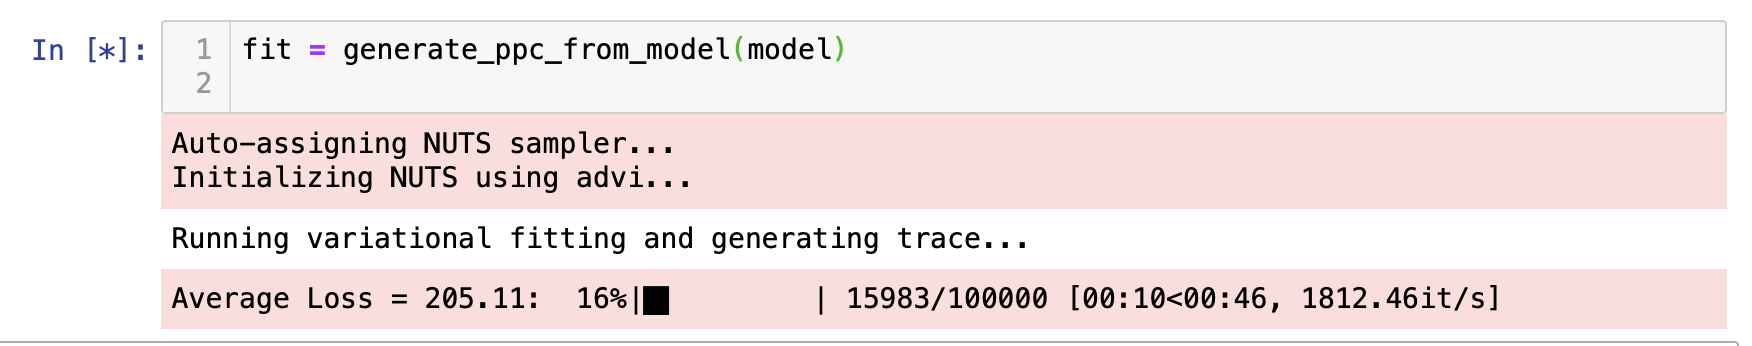

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 

PATH = "./images/r.png"
Image(filename = PATH)


Usually (but not always) the code is running forever like this, and if I stop it by interrupting the kernel with clicking the stop button, I get this error message:


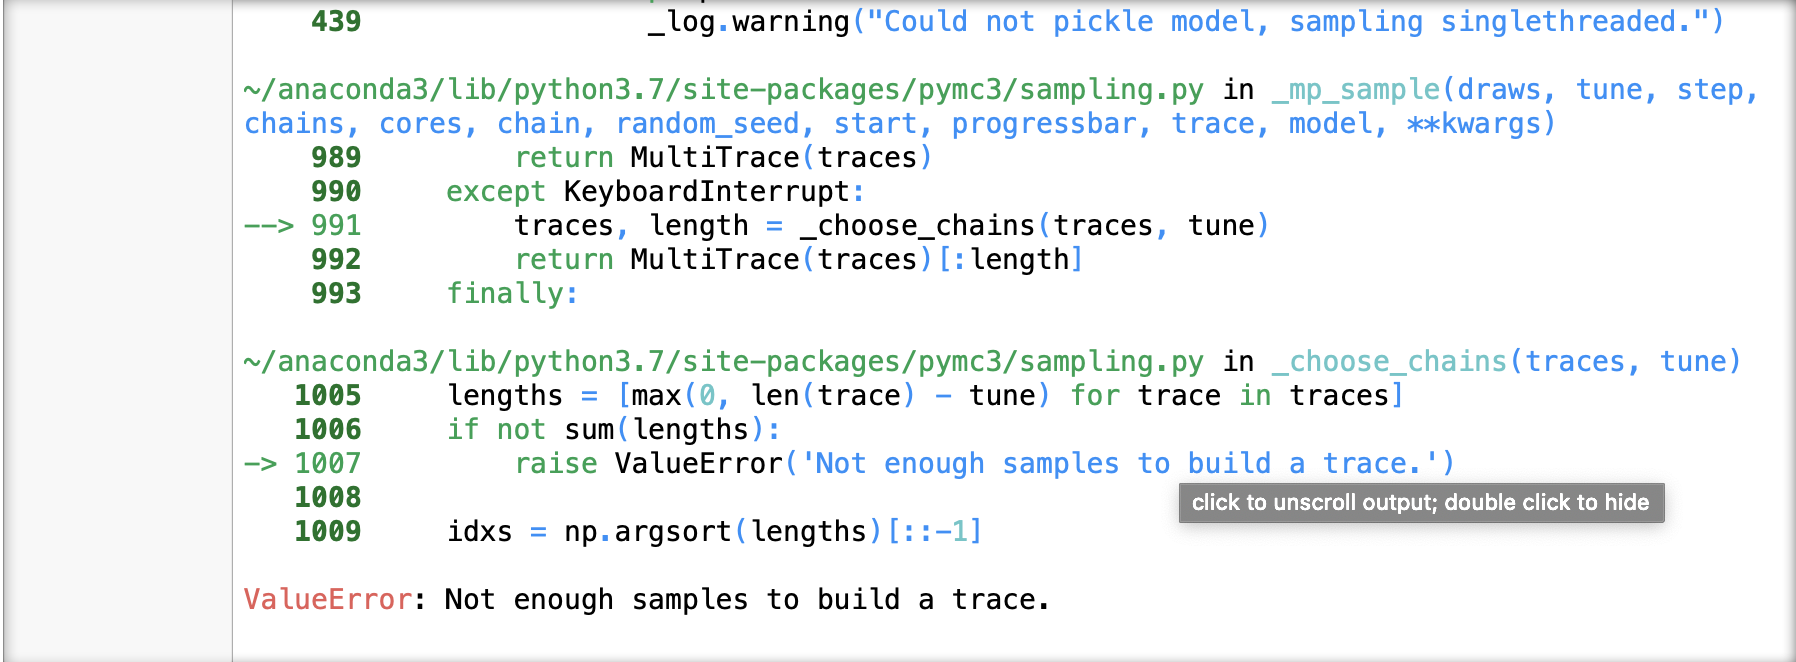

In [13]:
Image(filename="./images/e.png")


I am not sure why it is working on this notebook but not in my original notebook where I was practicing pymc3 and python.

I would like to ask you if there is anything I am doing wrong.

And if I give up using variational bayes and just use MCMC by doing:  
'trace = pm.sample(1000)'   
I am still having the same issue.

I thought maybe the environment can matter since the long jupyter notebook file was using Python3 while this notebook (Questions) using conda env.


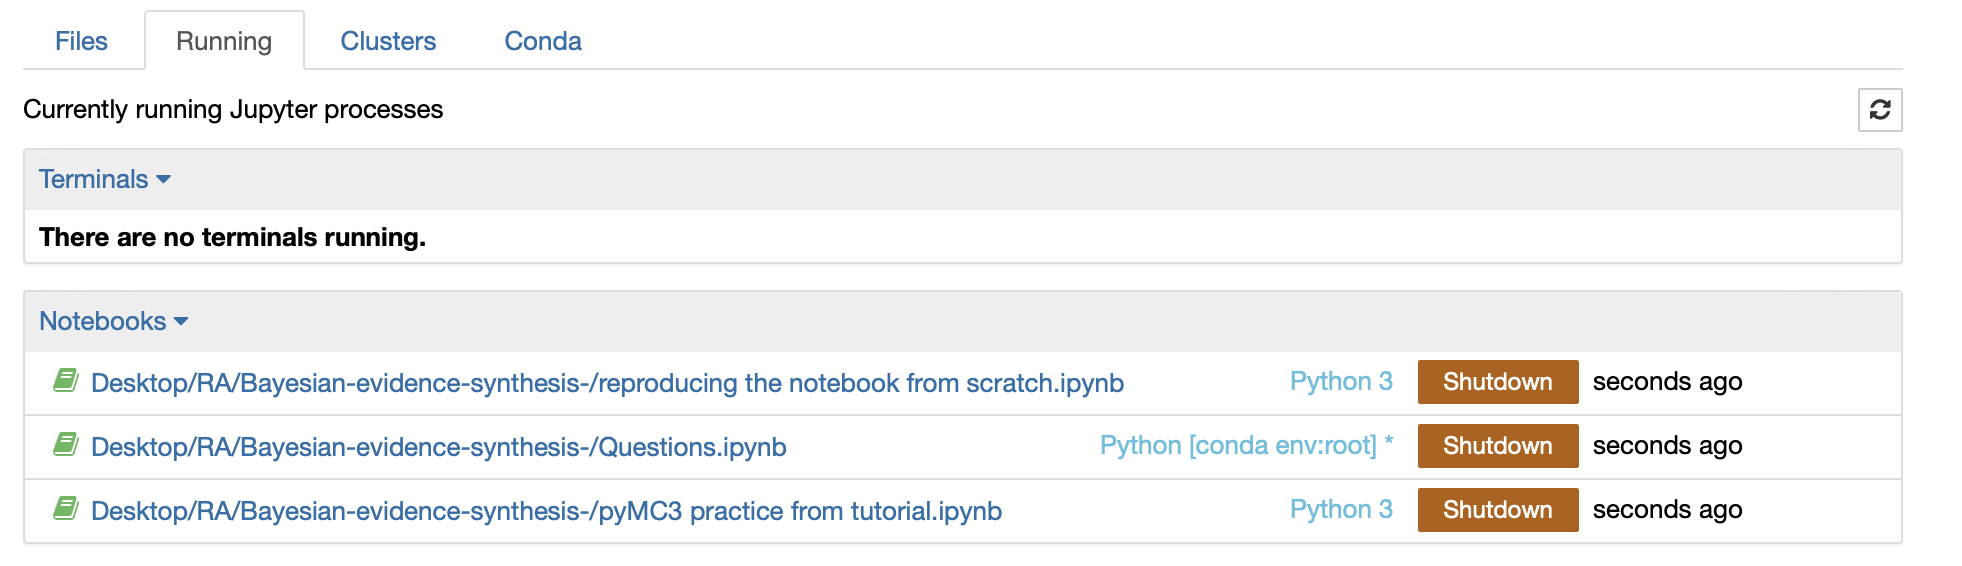

In [15]:
Image(filename='./images/Screen Shot 2019-11-21 at 1.38.16 PM.png')

But after I used conda env for my original long notebook (reproducing .... . ipynb), 
I am stll having the same issue.

Hence, **the issue is in general that 'sometimes it stops and stay at a certain cells that do MCMC/variational Bayes work.** in a jupyter notebook whereas it does not from another notebook.



# 2.  Why do we have two x values for 'overdoses' and 'deaths'?  
from the code:**

         # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Poisson('overdoses',mu=N*p,shape=(n_months,), observed=overdoses)
            
        if deaths is not None:
            x = pm.Poisson('deaths',mu=N*p*pd,shape=(n_months,), observed=deaths)
      
It doesn't matter because we are naming them differently as 'overdoses' and 'deaths'?

# 3. I am having different result for times series model from Adding in time variation chapter

In [16]:
# This is the model 
def create_timeseries_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            overdoses=None):
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    overdoses : numpy array
        overdose data. empty array is sampling from prior
    
    Returns
    -------
    
    Pymc3 model
    
    """
    
    # instantiate model
    model = pm.Model()

    # create elements of the model
    with model:
        # define population size random variable. PyMC3 needs a label for the RV as the first value.
        N = pm.Normal('N',mu=N_mean, sd=N_sd)

        # define random walk process
        w = GaussianRandomWalk('w',mu=mu_w, sd=sigma_w, shape=n_months, init=pm.Normal.dist(mu=logit(p0), sd=0.1))
        
        # convert random walk into probability
        p = pm.Deterministic('p',pm.math.invlogit(w))

        # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Binomial('x',n=tt.cast(N, 'int64'),p=p,shape=n_months,observed=overdoses)
    
    return model

In [17]:
# instantiate model
model = create_timeseries_model()

In [26]:
# with model:
#     v_params = pm.variational.advi(n=100000)
    
# with model:
#     prior_trace = pm.variational.sample_vp(v_params, draws=1000)
## Since this is 3.0 version of pymc3, I change this as follows:

with model:
    trace = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 245.06draws/s]


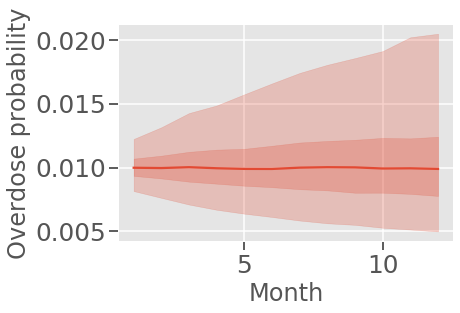

In [24]:
# defining a plotting function and plot using the function
def plot_data_timeseries(ys, xs=None,xlabel='Month',ylabel='Overdoses',new_plot=True,color = '#E24A33',
                        label=None):
    '''
    Plot 95 percentiles and interquartile range draws of time series data
    
    Parameters
    ----------
    
    ys : numpy array
        data to plot. In shape format (sample,time)
    x : numpy array
        1D array same size as ys 0 axis. Represents time-points
    xlabel : string
    ylabel : string
    new_plot : boolean
        used to indicate if plotting on a new figure
    color : str
        default color to plot
    label : str
        label for plot
        
    Returns
    -------
    
    None
    
    '''
    
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
        
    if new_plot: plt.figure();
        
    lc,liqr,m,uiqr,uc = np.percentile(ys,[2.5,25.,50.,75.,97.5],axis=0);
    plt.fill_between(xs,lc,uc,alpha=0.25,color=color);
    plt.fill_between(xs,liqr,uiqr,alpha=0.25,color=color);
    plt.plot(xs,m,color=color,label=label);
    plt.xlabel(xlabel); plt.ylabel(ylabel);
plot_data_timeseries(trace['p'],ylabel='Overdose probability');

This plot is different from the plot that Mike had from his notebook as follow:

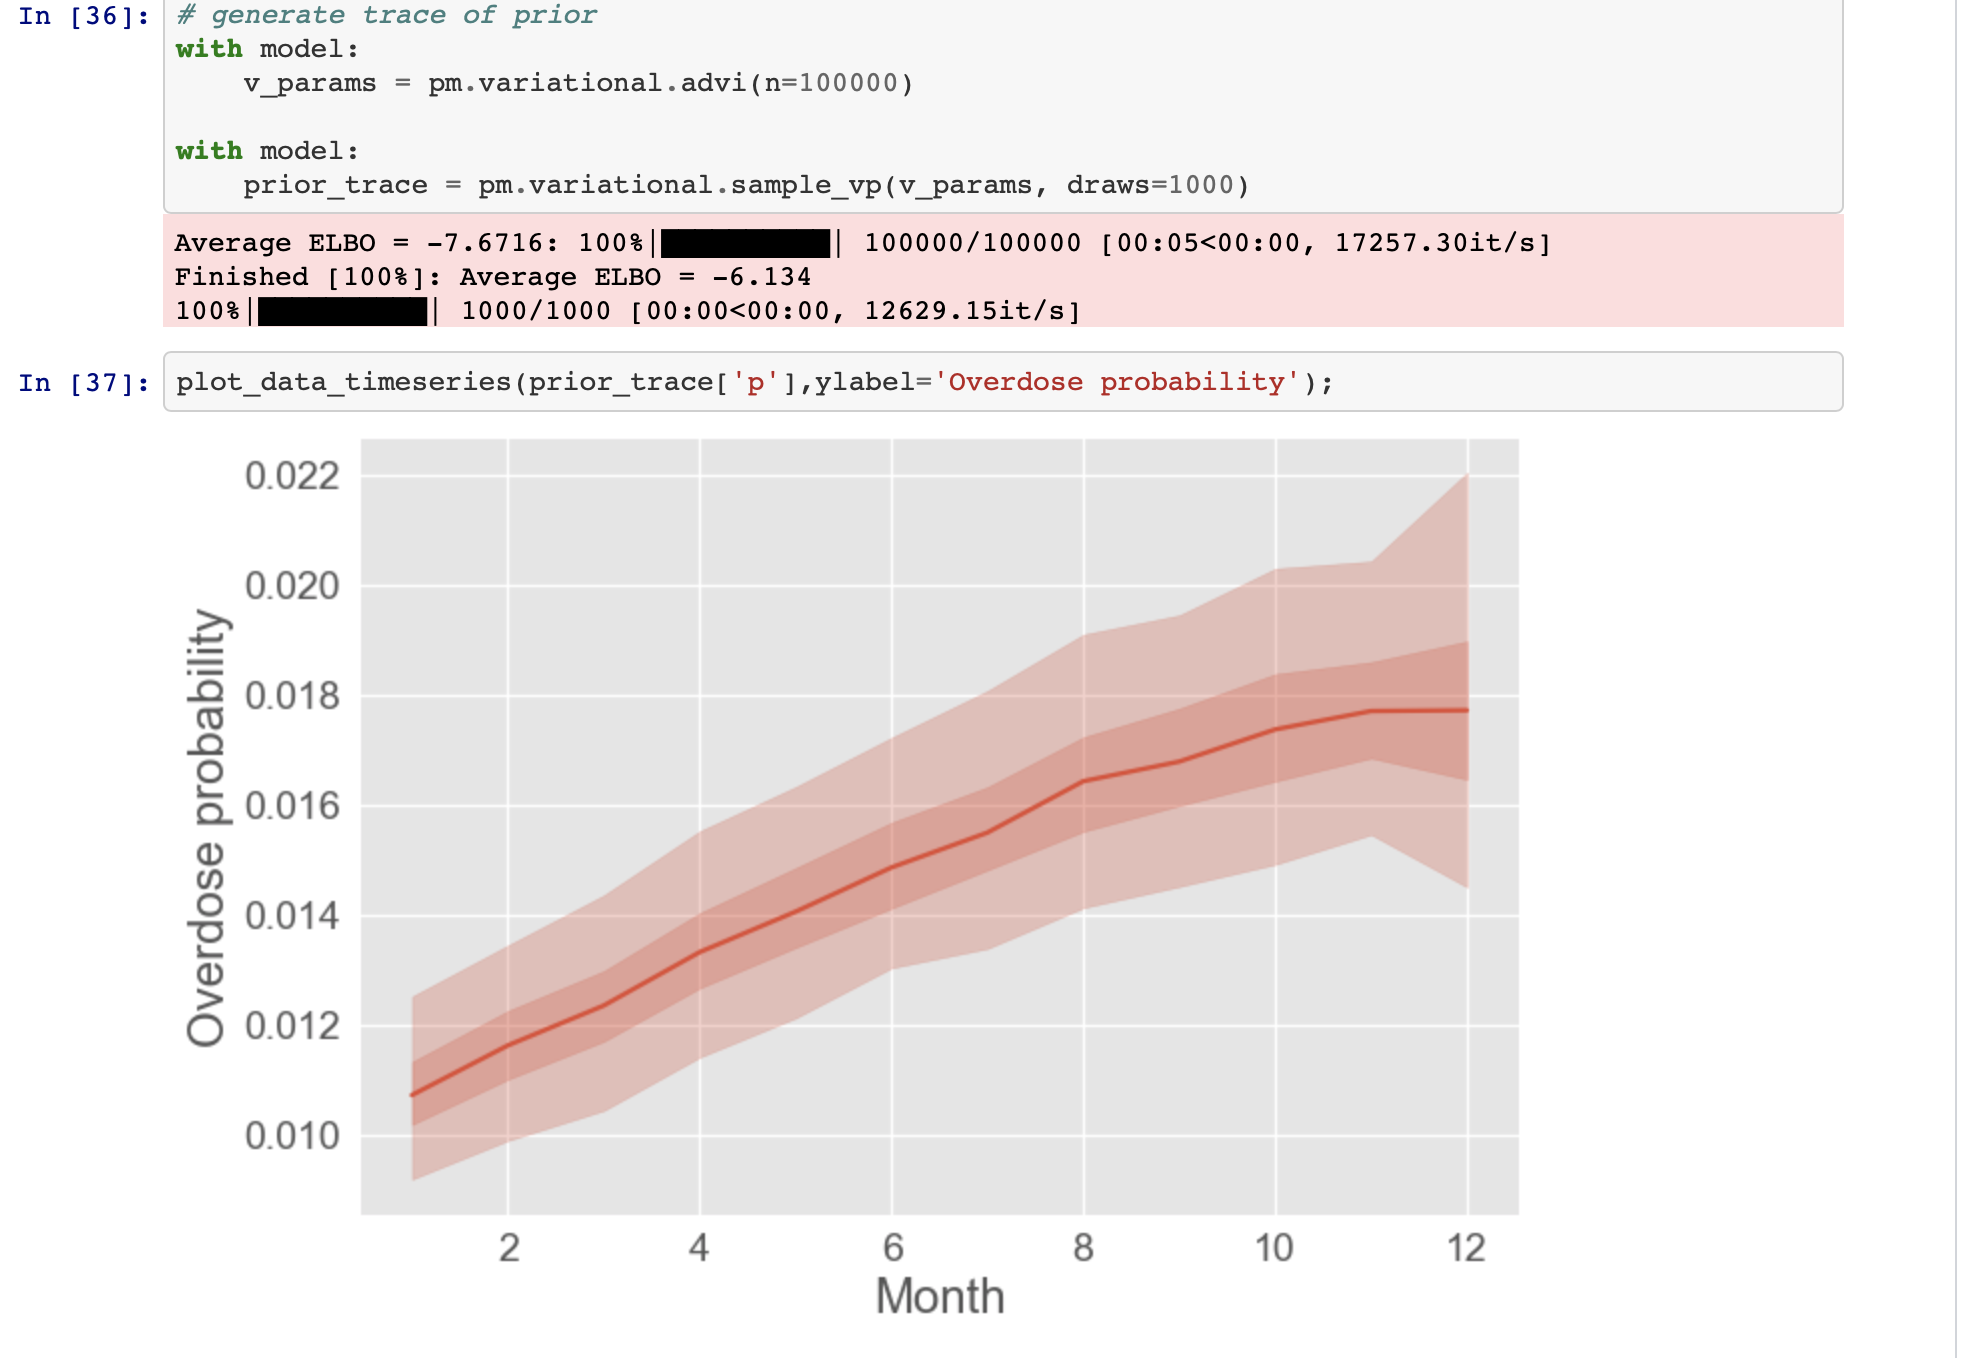

In [27]:
Image(filename='./images/mikes_p_overtime.png')

I guess this is because Mike is sampling from prior predictive distirbution while I am doing it from 
posterior distribution of parameters.  

Then how could I get the same result? I tried and got this error.

In [30]:
with model:
    prior_trace = pm.sample_prior_predictive()

ValueError: Cannot resolve inputs for ['w', 'p']